In [1]:
import torch
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from softmax import SoftmaxModel
import collections
from scipy.ndimage import gaussian_filter, convolve
import time
from dataloaders import train_dataloader, test_dataloader
from torch import nn, optim
from scipy.ndimage import gaussian_filter, convolve
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import structural_similarity as ssm
from utils import classes, c_to_i, get_orig, show_images

In [2]:
TRAIN_DIR = './data/processed/train/'
TEST_DIR = './data/processed/test/'

classes = os.listdir(TRAIN_DIR)
c_to_i = lambda x: classes.index(x)
i_to_c = lambda x: classes[x]

transformer = transforms.Compose([
    transforms.ToTensor(),
])

def show_img(im):
    plt.imshow(im.reshape(112, 92) / 2 + .5, cmap='gray')
    plt.show()
    
def one_hot(x):
    vec = [0] *len(classes)
    vec[x] = 1
    return vec
    
train =test= 0
train_x, train_y = ([0]) * 280, ([0]) * 280
test_x, test_y = ([0]) * 120, ([0]) * 120
asd = []

for c in os.listdir(TRAIN_DIR):
    for faces in os.listdir(TRAIN_DIR+c):
        img = np.array(Image.open(TRAIN_DIR+c+'/'+faces).convert('L'))
        train_x[train] = (img).flatten()
        train_y[train] = (c_to_i(c))
        train += 1

for c in os.listdir(TEST_DIR):
    for faces in os.listdir(TEST_DIR+c):
        img = np.array(Image.open(TEST_DIR+c+'/'+faces).convert('L'))
        test_x[test] = img.flatten()
        test_y[test] = (c_to_i(c))
        test += 1

train_x = np.stack([x.flatten() for x in train_x])
test_x = np.stack([x.flatten() for x in test_x])
test_y = np.array(test_y,  dtype=np.int64)
train_y = np.array(train_y, dtype=np.int64)

### Models

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.name = "ConvNet"
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear1 = nn.Linear(10304, 512)
        self.linear2 = nn.Linear(512, 40)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.view(x.shape[0], 1, 112, 92)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.dropout(F.relu(self.linear1(x)))
        x = F.log_softmax(self.linear2(x), dim=1)
        return x

In [4]:
def buildModel(model, lRate, plot=False, verbose=False):

    startTime = time.time()
    timeStr = time.strftime("%H:%M:%S", time.localtime(startTime))
    print("Starting at " + timeStr + " to build " + model.name + " model...")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lRate)
    train_losses, validate_losses, accuracy_data = [], [], []
    valid_loss_min = np.Inf
    
    best_accuracy = 0
    iteration_count = 0
    total_iteration = 0
    
    # as in the paper, if there is no improvment after 100 iterations
    # stop training
    while iteration_count < 100:
        total_iteration += 1
        if (total_iteration%100==0): print("epoch: " + str(total_iteration))
        running_loss = 0
        for images, labels in train_dataloader:
            output = model(images)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # epoch over
        iteration_count +=1
        
        validate_loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in test_dataloader:
                samples = model(images)
                pred = samples.argmax(dim=1)
                accuracy = (pred == labels).sum().item() / len(labels)
                
            model.train()
            train_loss = running_loss / len(train_dataloader)
            train_losses.append(train_loss)
            accuracy_data.append(accuracy)
            
            
            if accuracy > best_accuracy:  # if we improve our accuracy, set the iteration count to 0
                if verbose:
                    print("Epoch: {}.. ".format(total_iteration))
                    print('Accuracy increased ({:.2f} --> {:.2f}). Saving model ...'.format(
                        best_accuracy, accuracy))
                torch.save(model.state_dict(), './models/'+model.name+"_model.pt")
                iteration_count = 0
                best_accuracy = accuracy  # update best accuracy

    endTime = time.time()
    dur = endTime - startTime
    timeStr = time.strftime("%H:%M:%S", time.localtime(endTime))
    print("Finished at " + timeStr + ", duration in sec: " + str(int(dur)))
    print("Total number of iterations ", total_iteration,", with accuracy of ", best_accuracy)
    
    if (plot):
        fig = plt.figure(figsize=(10, 5))
        fig.suptitle("Model: " + model.name)
        ax1 = fig.add_subplot(1,2,1)
        ax1.plot(train_losses, label='Training loss')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('epochs')
        ax1.legend(frameon=False)
        ax2 = fig.add_subplot(1,2,2)
        ax2.plot(accuracy_data, label='Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('epochs')
        ax2.legend(frameon=False)
        plt.savefig("images/"+ model.name+"_model.png", bbox_inches='tight')
        plt.show()

    return model

Starting at 13:48:42 to build ConvNet model...
Epoch: 3.. 
Accuracy increased (0.00 --> 0.90). Saving model ...
Epoch: 8.. 
Accuracy increased (0.90 --> 1.00). Saving model ...
epoch: 100
Finished at 13:52:33, duration in sec: 231
Total number of iterations  108 , with accuracy of  1.0


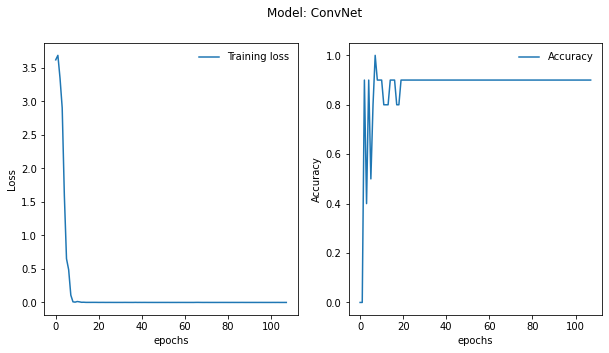

In [5]:
convnet = buildModel(ConvNet(), 0.01, True, True)

### Reconstruction attack

In [9]:
# values from paper with adjusted gamma and cost function
alpha = 5000
beta = 100
gamma = 0.1
delta = 0.1

# returns a vector with all costs for all labels
def my_cost(pred):
    cost = torch.ones(pred.shape) - pred
    return cost    

In [18]:
def invert(model, img, criterion, optimizer, lr, c, best_cost, best_x, i, b, beta, gamma):
    img = torch.Tensor(img).view(1, -1)
    if not img.requires_grad:
        img.requires_grad = True
        
    optimizer.zero_grad()
    pred = model(img)
    b -= 1

    
    # calculate cost
    cost = my_cost(F.softmax(pred))
    cost = cost.detach().numpy().flatten()[c]
    
    # calculate loss
    loss = criterion(pred, torch.LongTensor([c]))
    loss.backward()  
    
    img = torch.clamp(img - lr * img.grad, 0, 255)
    np_a = np.array([np.clip(x + np.random.normal(2, 2),0,255) for x in img.detach().numpy()])
    
    if cost < best_cost:
        print("Cost was updated, is now", cost,"was", best_cost)
        best_cost = cost
        best_x = img.detach().numpy()
        b = beta
    
    if cost >= best_cost and b <= 0:
        print("Cost doesn't improve after", beta, "iterations with a best value of", best_cost)
        best_cost = cost
        best_x = img.detach().numpy()
        return best_cost, best_x, b, np_a.reshape(1, -1), True
    
    if cost <= gamma:
        print("Cost is lower than gamma with a value of ", cost)
        best_cost = cost
        best_x = img.detach().numpy()
        return best_cost, best_x, b, np_a.reshape(1, -1), True
    
    return best_cost, best_x, b, np_a.reshape(1, -1), False

<ipython-input-18-57acc68569f4>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cost = my_cost(F.softmax(pred))


Cost was updated, is now 0.9741732 was 1
Cost was updated, is now 0.9730381 was 0.9741732
Cost was updated, is now 0.9724974 was 0.9730381
Cost was updated, is now 0.96283525 was 0.9724974
Cost was updated, is now 0.95888734 was 0.96283525
Cost was updated, is now 0.9551237 was 0.95888734
Cost was updated, is now 0.94957143 was 0.9551237
Cost was updated, is now 0.93952143 was 0.94957143
Cost was updated, is now 0.9384619 was 0.93952143
Cost was updated, is now 0.9288016 was 0.9384619
Cost doesn't improve after  100  iterations with a best value of  0.9288016


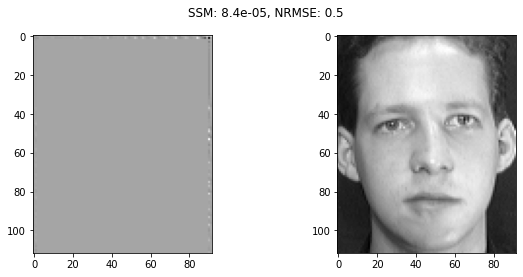

Cost was updated, is now 0.9730974 was 1
Cost was updated, is now 0.97212744 was 0.9730974
Cost was updated, is now 0.9704188 was 0.97212744
Cost doesn't improve after  100  iterations with a best value of  0.9704188


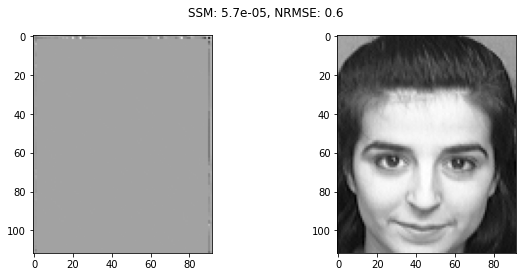

Cost was updated, is now 0.9762931 was 1
Cost doesn't improve after  100  iterations with a best value of  0.9762931


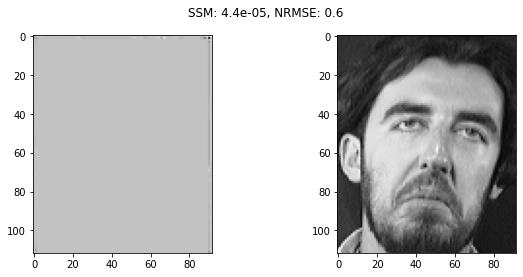

Cost was updated, is now 0.97412 was 1
Cost was updated, is now 0.9721581 was 0.97412
Cost was updated, is now 0.97117734 was 0.9721581
Cost was updated, is now 0.96934 was 0.97117734


KeyboardInterrupt: 

In [19]:
startTime = time.time()
timeStr = time.strftime("%H:%M:%S", time.localtime(startTime))
show = True
save = True
mse_all, nrmsev_all, ssmv_all, epochs = [],[],[],[]
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(softmax.parameters(), lr=delta)
test_x = get_orig()
rec_x = np.zeros((40,112,92), dtype='float32')

for c in classes:
    best_x,best_cost='',1
    img = np.zeros_like(test_x[0])
    b = beta
    for i in range(alpha):
        best_cost, best_x, b, img, stop = invert(convnet, img, criterion, optimizer, 
                                              delta, c_to_i(c), best_cost, best_x, i, 
                                              b, beta, gamma)
        if stop:
            epochs.append(i)
            break
    orig = test_x[c_to_i(c)]
    rec = best_x.reshape(112, 92)
    rec_x[c_to_i(c)] = rec
    ssmv = ssm(rec,orig)
    msev = mse(rec,orig)
    nrmsev = nrmse(rec,orig)
    mse_all.append(msev)
    nrmsev_all.append(nrmsev)
    ssmv_all.append(ssmv)
    
    if (show or save):
        fig = plt.figure(figsize=(10, 4))
        fig.suptitle("SSM: {:.1e}, NRMSE: {:.1f}".format(ssmv,nrmsev))
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(rec, cmap='gray')
        ax2 = fig.add_subplot(1,2,2)
        ax2.imshow(orig, cmap='gray')
        if save:
            plt.savefig(f'./data/results/class_{c}.png')
        if show:
            plt.show()
        
endTime = time.time()
dur = endTime - startTime
print("Duration in sec: " + str(int(dur)))

In [62]:
# Calculating means performance values of all images
print('MSE mean',np.mean(mse_all))
print('NRMSE mean',np.mean(nrmsev_all))
print('SSM mean',np.mean(ssmv_all))
print('Epochs mean',np.mean(epochs))

MSE mean 14551.60220939985
NRMSE mean 264.9349131754242
SSM mean 0.0016527008567844156
Epochs mean 1.325


0